### Определение ССЗ

ссылка на соревнование - https://mlbootcamp.ru/ru/round/12/sandbox/

В рамках конкурса вам нужно предсказать наличие сердечно-сосудистых заболеваний по результатам классического врачебного осмотра. Датасет сформирован из 100.000 реальных клинических анализов, и в нём используются признаки, которые можно разбить на 3 группы:

 

Объективные признаки:

 - Возраст
 - Рост
 - Вес
 - Пол
 

Результаты измерения:

 - Артериальное давление верхнее и нижнее
 - Холестерин
 - Глюкоза
 

Субъективные признаки:

 - Курение
 - Употребление Алкоголя
 - Физическая активность
 

Возраст дан в днях. Значения показателей холестерина и глюкозы представлены одним из трех классов: норма, выше нормы, значительно выше нормы. Значения субъективных признаков — бинарны.

Все показатели даны на момент осмотра.

Таргет - наличие сердечно-сосудистых заболеваний (ССЗ)

#### Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import roc_curve, roc_auc_score, log_loss, precision_recall_curve, confusion_matrix
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler

In [2]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in test_columns:
            if col_ not in self.columns:
                X[col_] = 0
        return X[self.columns]

In [3]:
def roc_auc_graph(y_true, y_score, title):
    sns.set(font_scale=1.1)
    sns.set_color_codes("muted")

    plt.figure(figsize=(4, 3))
    fpr, tpr, thresholds_ = roc_curve(y_true, y_score, pos_label=1)
    lw = 2
    plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC curve - {title}')
    plt.savefig("ROC.png")
    plt.show()

In [4]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
df = pd.read_csv('train_case2.csv', ';')
df.head(3)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1


Разделим наши данные на тренировочную и тестовую выборки

In [6]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df.drop('cardio', 1), 
                                                    df['cardio'], random_state=0)

К полям:
- gender, cholesterol применим OHE-кодирование
- age, height, weight, ap_hi, ap_lo - standardScaler
- gluc, smoke, alco, active - оставим пока как есть

In [7]:
continuos_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']
cat_cols = ['gender', 'cholesterol']
base_cols = ['gluc', 'smoke', 'alco', 'active']

continuos_transformers = []
cat_transformers = []
base_transformers = []

for cont_col in continuos_cols:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in cat_cols:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))
    
for base_col in base_cols:
    base_transformer = Pipeline([
                ('selector', NumberSelector(key=base_col))
            ])
    base_transformers.append((base_col, base_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [8]:
feats = FeatureUnion(continuos_transformers+cat_transformers+base_transformers)
feature_processing = Pipeline([('feats', feats)])

feature_processing.fit_transform(X_train)

array([[-1.73391771,  0.6873301 ,  0.74843904, ...,  1.        ,
         0.        ,  1.        ],
       [-1.67343538,  0.07758923, -0.29640123, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.13738132,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 1.17775864,  1.17512278, -0.15708919, ...,  0.        ,
         0.        ,  1.        ],
       [-0.47190715, -1.38578883,  0.74843904, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.38174619,  0.56538192, -0.08743318, ...,  0.        ,
         0.        ,  1.        ]])

Добавим классификатор и запустим кросс-валидацию

In [9]:
r_s = 42
classifier_list = [RandomForestClassifier(random_state = r_s),
                   LogisticRegression(random_state = r_s),
                  GradientBoostingClassifier(random_state = r_s)]
classifier_list

[RandomForestClassifier(random_state=42),
 LogisticRegression(random_state=42),
 GradientBoostingClassifier(random_state=42)]

In [10]:
clf_list = [Pipeline([('features',feats),('classifier', clf)]) for clf in classifier_list]
cv_score = {str(classifier_list[ind]): (np.mean(cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')),
                                         np.std(cross_val_score(classifier, X_train, y_train, cv=16, scoring='roc_auc')))
             for ind, classifier in enumerate(clf_list)}

for key in cv_score:
    print(f'{key} - CV score is {cv_score[key][0]}+-{cv_score[key][1]}')

RandomForestClassifier(random_state=42) - CV score is 0.7734501681056019+-0.007171140345435727
LogisticRegression(random_state=42) - CV score is 0.7867401104915408+-0.00852135511666111
GradientBoostingClassifier(random_state=42) - CV score is 0.8025124517417064+-0.007075372179995901


In [11]:
#обучим пайплайн на всем тренировочном датасете
y_score_dict = {}
for ind,clf in enumerate(clf_list):
    clf.fit(X_train, y_train)
    y_score_dict[str(classifier_list[ind])] = clf.predict_proba(X_test)[:, 1]
y_score_dict

{'RandomForestClassifier(random_state=42)': array([0.31, 0.17, 0.03, ..., 0.05, 0.82, 0.73]),
 'LogisticRegression(random_state=42)': array([0.21919629, 0.24759828, 0.40484498, ..., 0.16941878, 0.70519218,
        0.75098778]),
 'GradientBoostingClassifier(random_state=42)': array([0.1585145 , 0.19609409, 0.36242795, ..., 0.13083914, 0.73939789,
        0.78147122])}

Посчитаем precision/recall/f_score

In [12]:
b=1
metrics = pd.DataFrame(columns=['thresholds', 'precision', 'recall', 'roc_auc', 'log_loss', 'f_score'])
for key in y_score_dict:
    precision, recall, thresholds = precision_recall_curve(y_test.values, y_score_dict[key])
    fscore = (1+b**2)*(precision * recall) / (b**2*precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    roc_auc = roc_auc_score(y_true=y_test, y_score=y_score_dict[key])
    logloss = log_loss(y_true=y_test, y_pred=y_score_dict[key])
    metrics.loc[key[:key.find('(')]] = [thresholds[ix], precision[ix], recall[ix], roc_auc, logloss, fscore[ix]]
    
metrics

,thresholds,precision,recall,roc_auc,log_loss,f_score
RandomForestClassifier,0.350000,0.642669,0.815553,0.771037,0.599298,0.718863
LogisticRegression,0.386937,0.647431,0.837558,0.784035,0.577960,0.730323
GradientBoostingClassifier,0.394947,0.697848,0.788134,0.802615,0.539746,0.740248


Нарисуем roc auc кривую (кстати, наверное неплохо бы ее вынести в отдельную функцию)

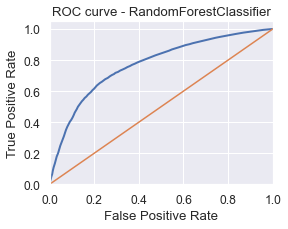

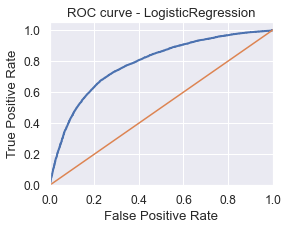

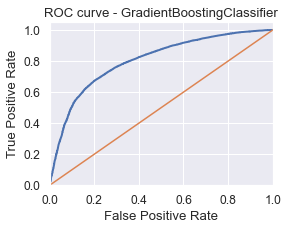

In [13]:
for key in y_score_dict:
    roc_auc_graph(y_true=y_test, y_score=y_score_dict[key], title=key[:key.find('(')])

Посмотрим на матрицу ошибок

Confusion matrix, without normalization
[[4991 3829]
 [1663 7017]]


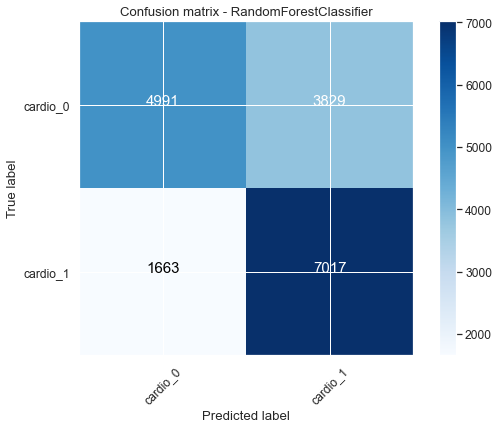

Confusion matrix, without normalization
[[4861 3959]
 [1411 7269]]


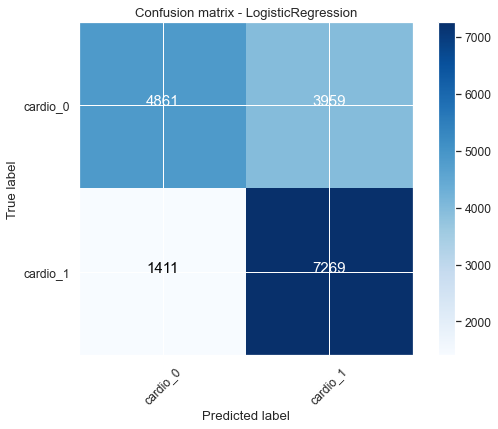

Confusion matrix, without normalization
[[5858 2962]
 [1840 6840]]


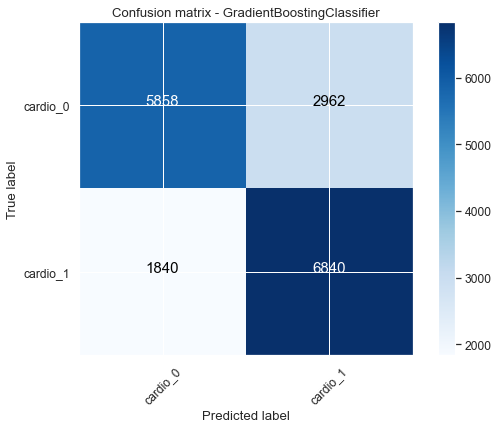

In [14]:
for key in y_score_dict:
    font = {'size' : 15}

    plt.rc('font', **font)
    cnf_matrix = confusion_matrix(y_test, y_score_dict[key]>metrics.loc[key[:key.find("(")],'thresholds'])
    plt.figure(figsize=(8, 6))
    plot_confusion_matrix(cnf_matrix, classes=['cardio_0', 'cardio_1'],
                          title=f'Confusion matrix - {key[:key.find("(")]}')
    plt.savefig("conf_matrix.png")
    plt.show()

### Домашнее задание

1. обучить несколько разных моделей на наборе данных ССЗ (train_case2.csv): логрег, бустинг, лес и т.д - на ваш выбор 2-3 варианта
2. при обучении моделей обязательно использовать кроссвалидацию
3. вывести сравнение полученных моделей по основным метрикам классификации: pr/rec/auc/f_score (можно в виде таблицы, где строки - модели, а столбцы - метрики)
4. сделать выводы о том, какая модель справилась с задачей лучше других
5. (опциональный вопрос) какая метрика (precision_recall_curve или roc_auc_curve) больше подходит в случае сильного дисбаланса классов? (когда объектов одного из классов намного больше чем другого). 

p.s.В вопросе проще разобраться, если вспомнить оси на графике roc auc curve и рассмотреть такой пример:

Имеется 100000 объектов, из которых только 100 - класс "1" (99900 - класс "0", соответственно). 
Допустим, у нас две модели:

- первая помечает 100 объектов как класс 1, но TP = 90
- вторая помечает 1000 объектов как класс 1, но TP такой же - 90

Какая модель лучше и почему? И что позволяет легче сделать вывод - roc_auc_curve или precision_recall_curve?

Ответ на 4. В целом, градиентный бустинг лучше справился с задачей. У него лучше precision при незначительно меньшем recall. 
Но если брать recall как более важную метрику, то логистическая регрессия лучше.<br>
Ответ на 5.
В данном случае метрика precision_recall_curve более показательна, так как быстрее позволит отсеять вторую модель, 
так как она дает очень плохую точность

1) В первой модели precision = 90 / 100 = 0.9<br>
2) Во второй модели precision = 90 / 1000 = 0.09 
